# Importing Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', 45)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [ ]:
combined_df.sample(10)

# Understanding the Big Picture

In [4]:
number_of_rows = combined_df.shape[0]
number_of_columns = combined_df.shape[1]

print(f"The dataset has {number_of_rows} rows and {number_of_columns} columns.")

The dataset has 104682 rows and 49 columns.


In [ ]:
combined_df.info()

In [6]:
combined_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Checking if there are any duplicate rows

In [7]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [ ]:
combined_df['tourney_date'] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df.head()

Deleting unnecessary columns:

In [ ]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry"]

combined_df.drop(columns=["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"], inplace=True)

combined_df.columns

Creating new columns:

In [ ]:
combined_df["total_points"] = combined_df["w_svpt"]+combined_df["l_svpt"]
combined_df.sample(7)

# Univariate Analysis

In [ ]:
combined_df.surface.value_counts()


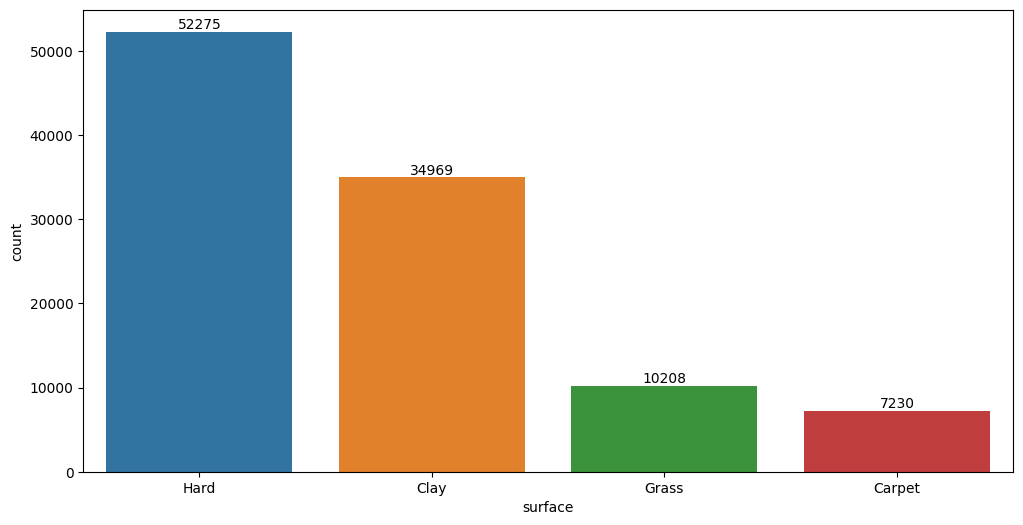

In [25]:
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
plt.show()

In [ ]:
combined_df.best_of.value_counts()

In [ ]:
combined_df.winner_hand.value_counts()

In [ ]:
combined_df.loser_hand.value_counts()